In [273]:
import pandas as pd
import numpy as np

In [274]:
train = pd.read_csv('/home/jupyter/mnt/s3/bac2/train.csv', index_col=0)

# Text preprocessing

In [275]:
from nltk.tokenize import RegexpTokenizer

tokenizer = RegexpTokenizer(r'\w+')

train["tokens"] = train["sentence"].apply(tokenizer.tokenize)

In [276]:
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /home/jupyter/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/jupyter/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/jupyter/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [277]:
from nltk.corpus import stopwords

stop_words = stopwords.words('russian')

def remove_stopwords(words: np.array):
    words = list(map(lambda x: x.lower(), words))
    return [s.lower() for s in list(set(words).difference(set(stop_words)))]

train["norm"] = train["tokens"].apply(remove_stopwords)

In [278]:
from nltk.stem import WordNetLemmatizer
from pymorphy2 import MorphAnalyzer

def lemma_pymorphy(words):
    return [lemmatizer.parse(s)[0].normal_form for s in words]

lemmatizer = MorphAnalyzer()
train["lemma"] = train.norm.apply(lemma_pymorphy)
train["lemma_string"] = train.lemma.apply(lambda x: " ".join(x))

## Wordcloud

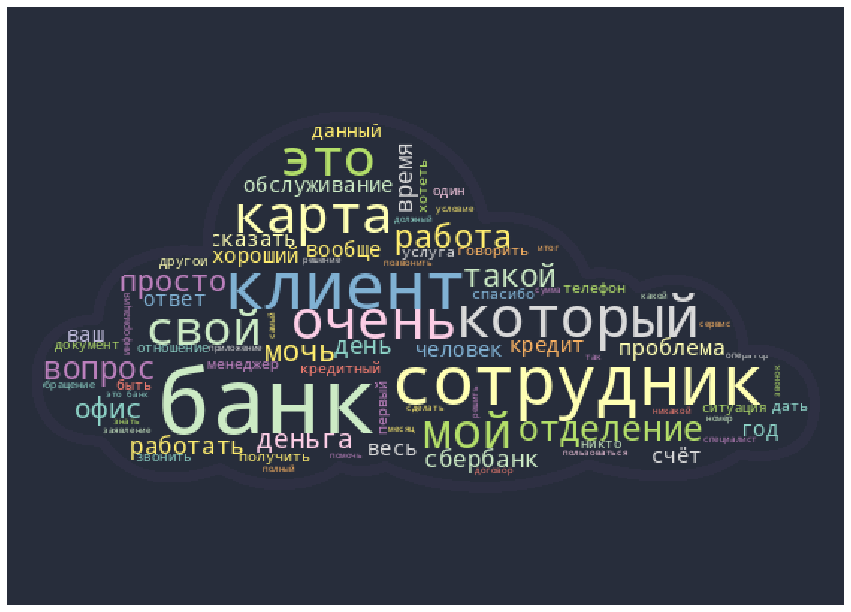

In [279]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from PIL import Image

text_all_sent = ' '.join(train.lemma_string)

cake_mask = np.array(Image.open('/home/jupyter/mnt/s3/bac2/cloud_hd.png'))

cloud = WordCloud(mask=cake_mask, contour_width=10, contour_color='#2e3043', background_color='#272d3b', colormap='Set3', max_words=80).generate(text_all_sent)

fig, ax = plt.subplots(figsize=(15, 15))
ax.imshow(cloud)
ax.set_axis_off()

In [280]:
fig.savefig('/home/jupyter/mnt/s3/bac2/media/all_sentiments.svg', format='svg', dpi=1200)

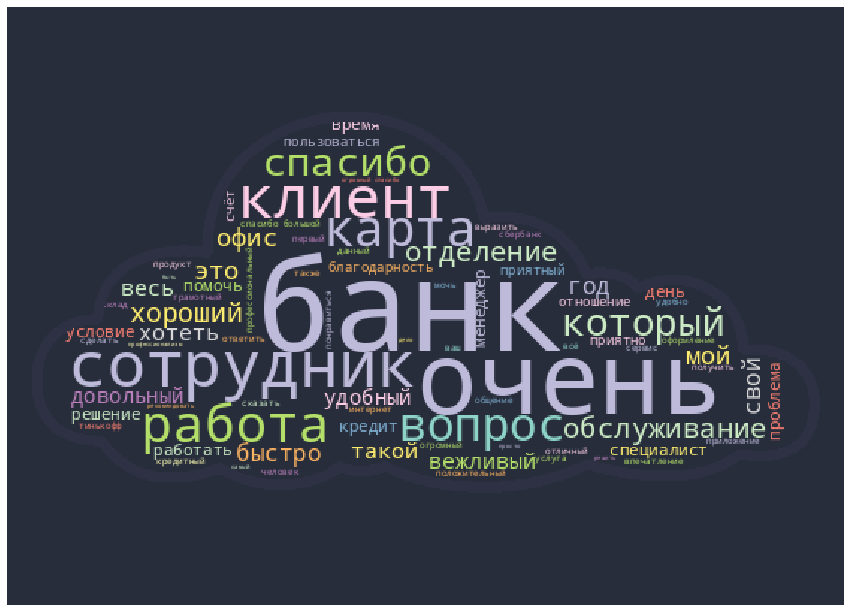

In [281]:
text_positive_sent = ' '.join(train.lemma_string[train.sentiment == "+"])
 
cloud = WordCloud(mask=cake_mask, contour_width=10, contour_color='#2e3043', background_color='#272d3b', colormap='Set3', max_words=80).generate(text_positive_sent)
 
fig, ax = plt.subplots(figsize=(15, 15))
ax.imshow(cloud)
ax.set_axis_off()

fig.savefig('/home/jupyter/mnt/s3/bac2/media/positive_sentiments.svg', format='svg', dpi=1200)

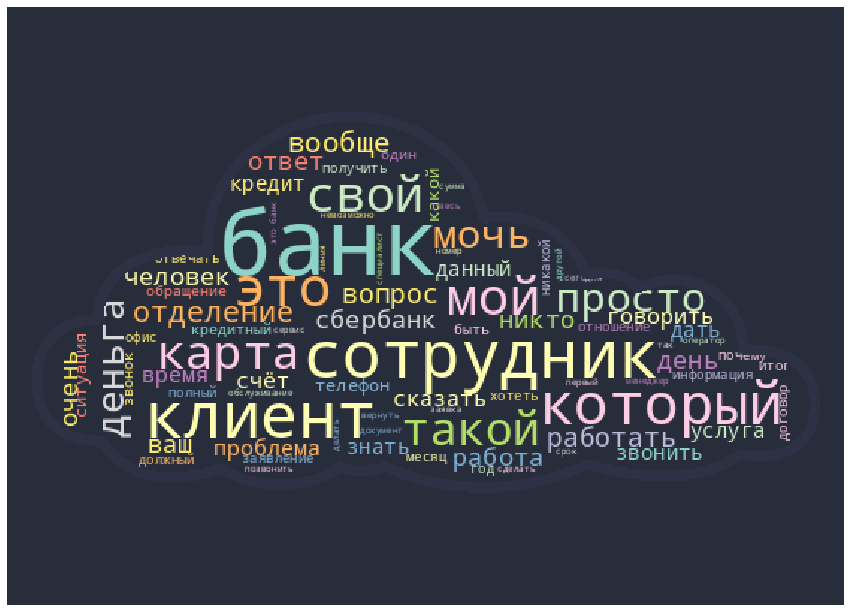

In [282]:
text_negative_sent = ' '.join(train.lemma_string[train.sentiment == "−"])

cloud = WordCloud(mask=cake_mask, contour_width=10, contour_color='#2e3043', background_color='#272d3b', colormap='Set3', max_words=80).generate(text_negative_sent)
 
fig, ax = plt.subplots(figsize=(15, 15))
ax.imshow(cloud)
ax.set_axis_off()

fig.savefig('/home/jupyter/mnt/s3/bac2/media/negative_sentiments.svg', format='svg', dpi=1200)

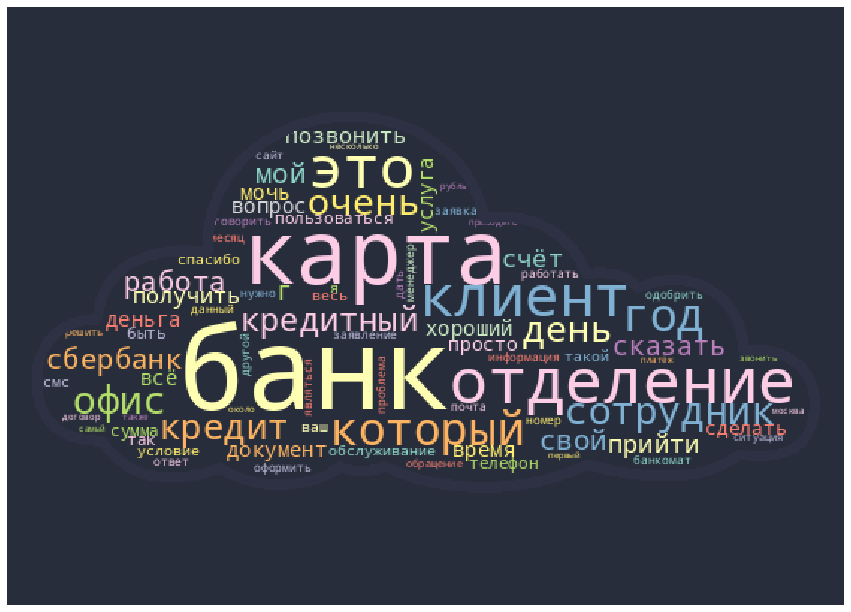

In [283]:
text_neutral_sent = ' '.join(train.lemma_string[train.sentiment == "?"])
 
cloud = WordCloud(mask=cake_mask, contour_width=10, contour_color='#2e3043', background_color='#272d3b', colormap='Set3', max_words=80).generate(text_neutral_sent)
 
fig, ax = plt.subplots(figsize=(15, 15))
ax.imshow(cloud)
ax.set_axis_off()

fig.savefig('/home/jupyter/mnt/s3/bac2/media/neutral_sentiments.svg', format='svg', dpi=1200)

# Categories

In [284]:
cat = train[train['2category'].notna()]
cat_2 = cat.drop('1category', axis=1)
cat_2.rename(columns={'2category': '1category'}, inplace=True)
train_2 = train.drop('2category', axis=1)
train_new = pd.concat([train_2, cat_2])
train_new.head()

,sentence,1category,sentiment,tokens,norm,lemma,lemma_string
4754,При этом всегда получал качественные услуги.,Communication,+,"[При, этом, всегда, получал, качественные, усл...","[качественные, получал, услуги]","[качественный, получать, услуга]",качественный получать услуга
4417,"Не вижу, за что хотя бы 2 поставить, сервис на 1!",?,−,"[Не, вижу, за, что, хотя, бы, 2, поставить, се...","[1, хотя, вижу, поставить, 2, сервис]","[1, хотя, видеть, поставить, 2, сервис]",1 хотя видеть поставить 2 сервис
3629,"Вот так ""Мой любимый"" банк МКБ меня обманул.",?,−,"[Вот, так, Мой, любимый, банк, МКБ, меня, обма...","[любимый, мкб, банк, обманул]","[любимый, мкб, банк, обмануть]",любимый мкб банк обмануть
11640,Отвратительное отношение к клиентам.,Communication,−,"[Отвратительное, отношение, к, клиентам]","[отвратительное, клиентам, отношение]","[отвратительный, клиент, отношение]",отвратительный клиент отношение
5571,"Всегда в любое время дня и ночи помогут, ответ...",Communication,+,"[Всегда, в, любое, время, дня, и, ночи, помогу...","[время, решат, ответят, ночи, любое, помогут, ...","[время, решить, ответить, ночь, любой, помочь,...",время решить ответить ночь любой помочь день


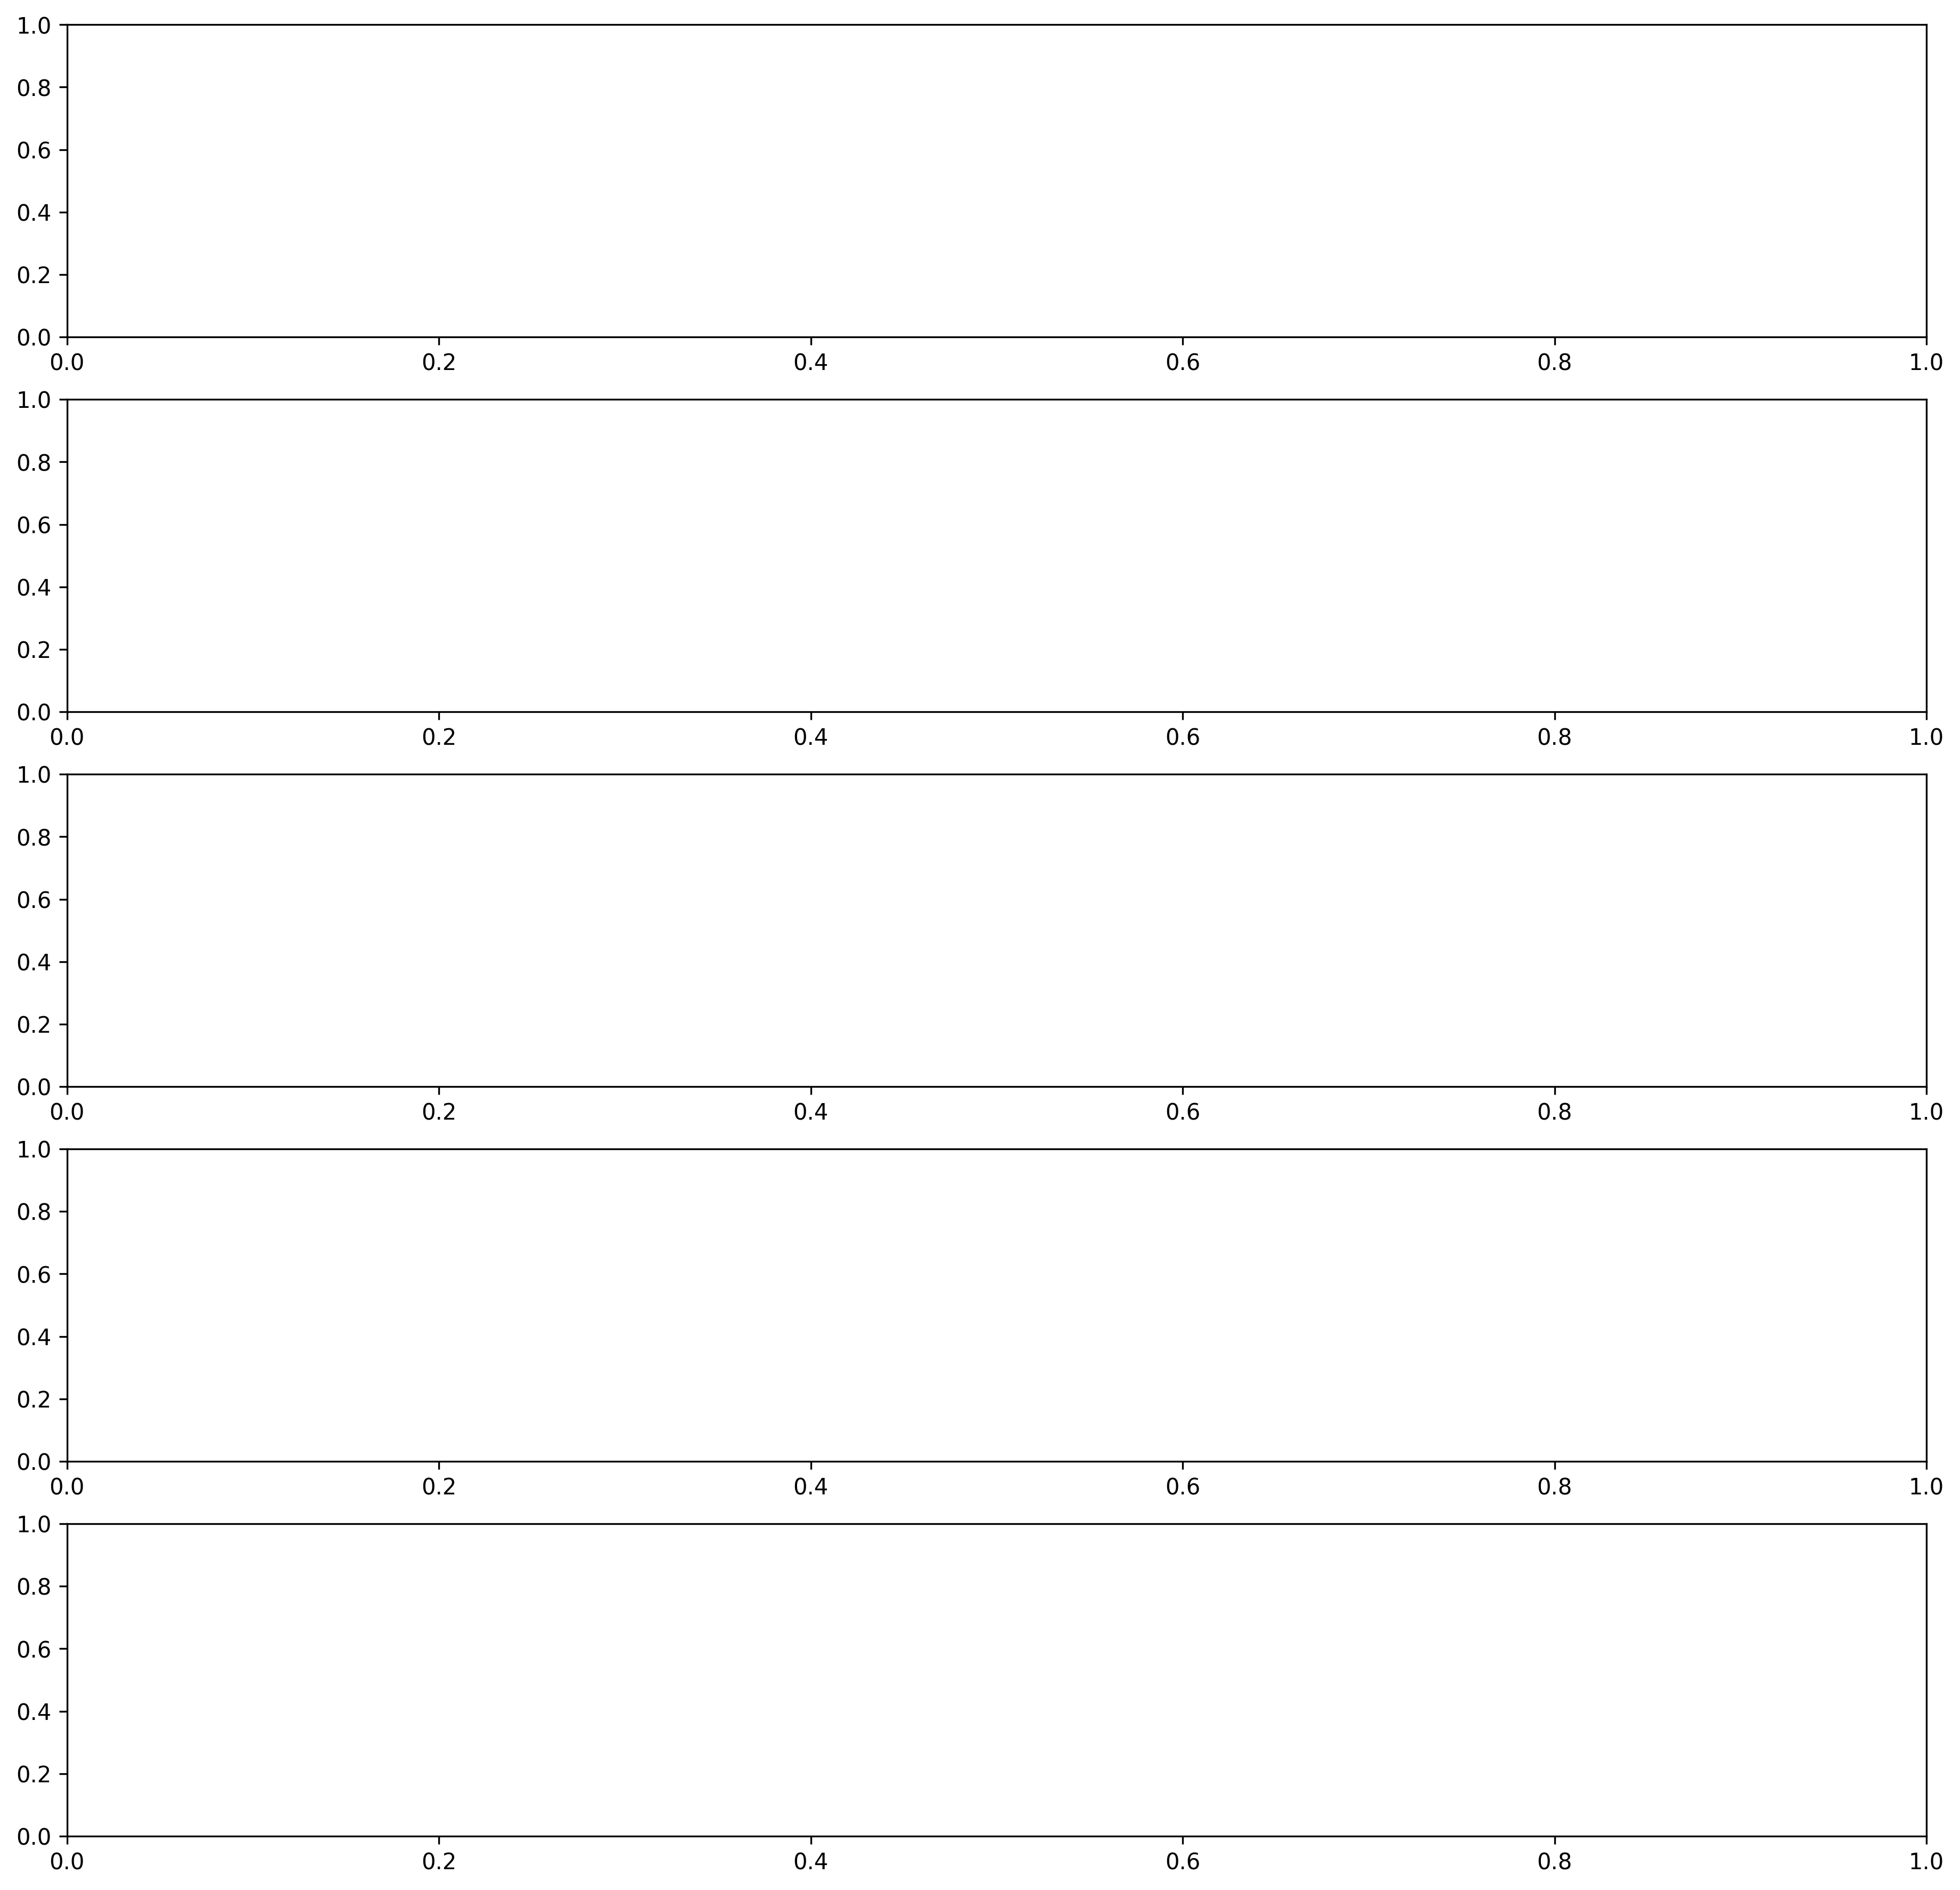

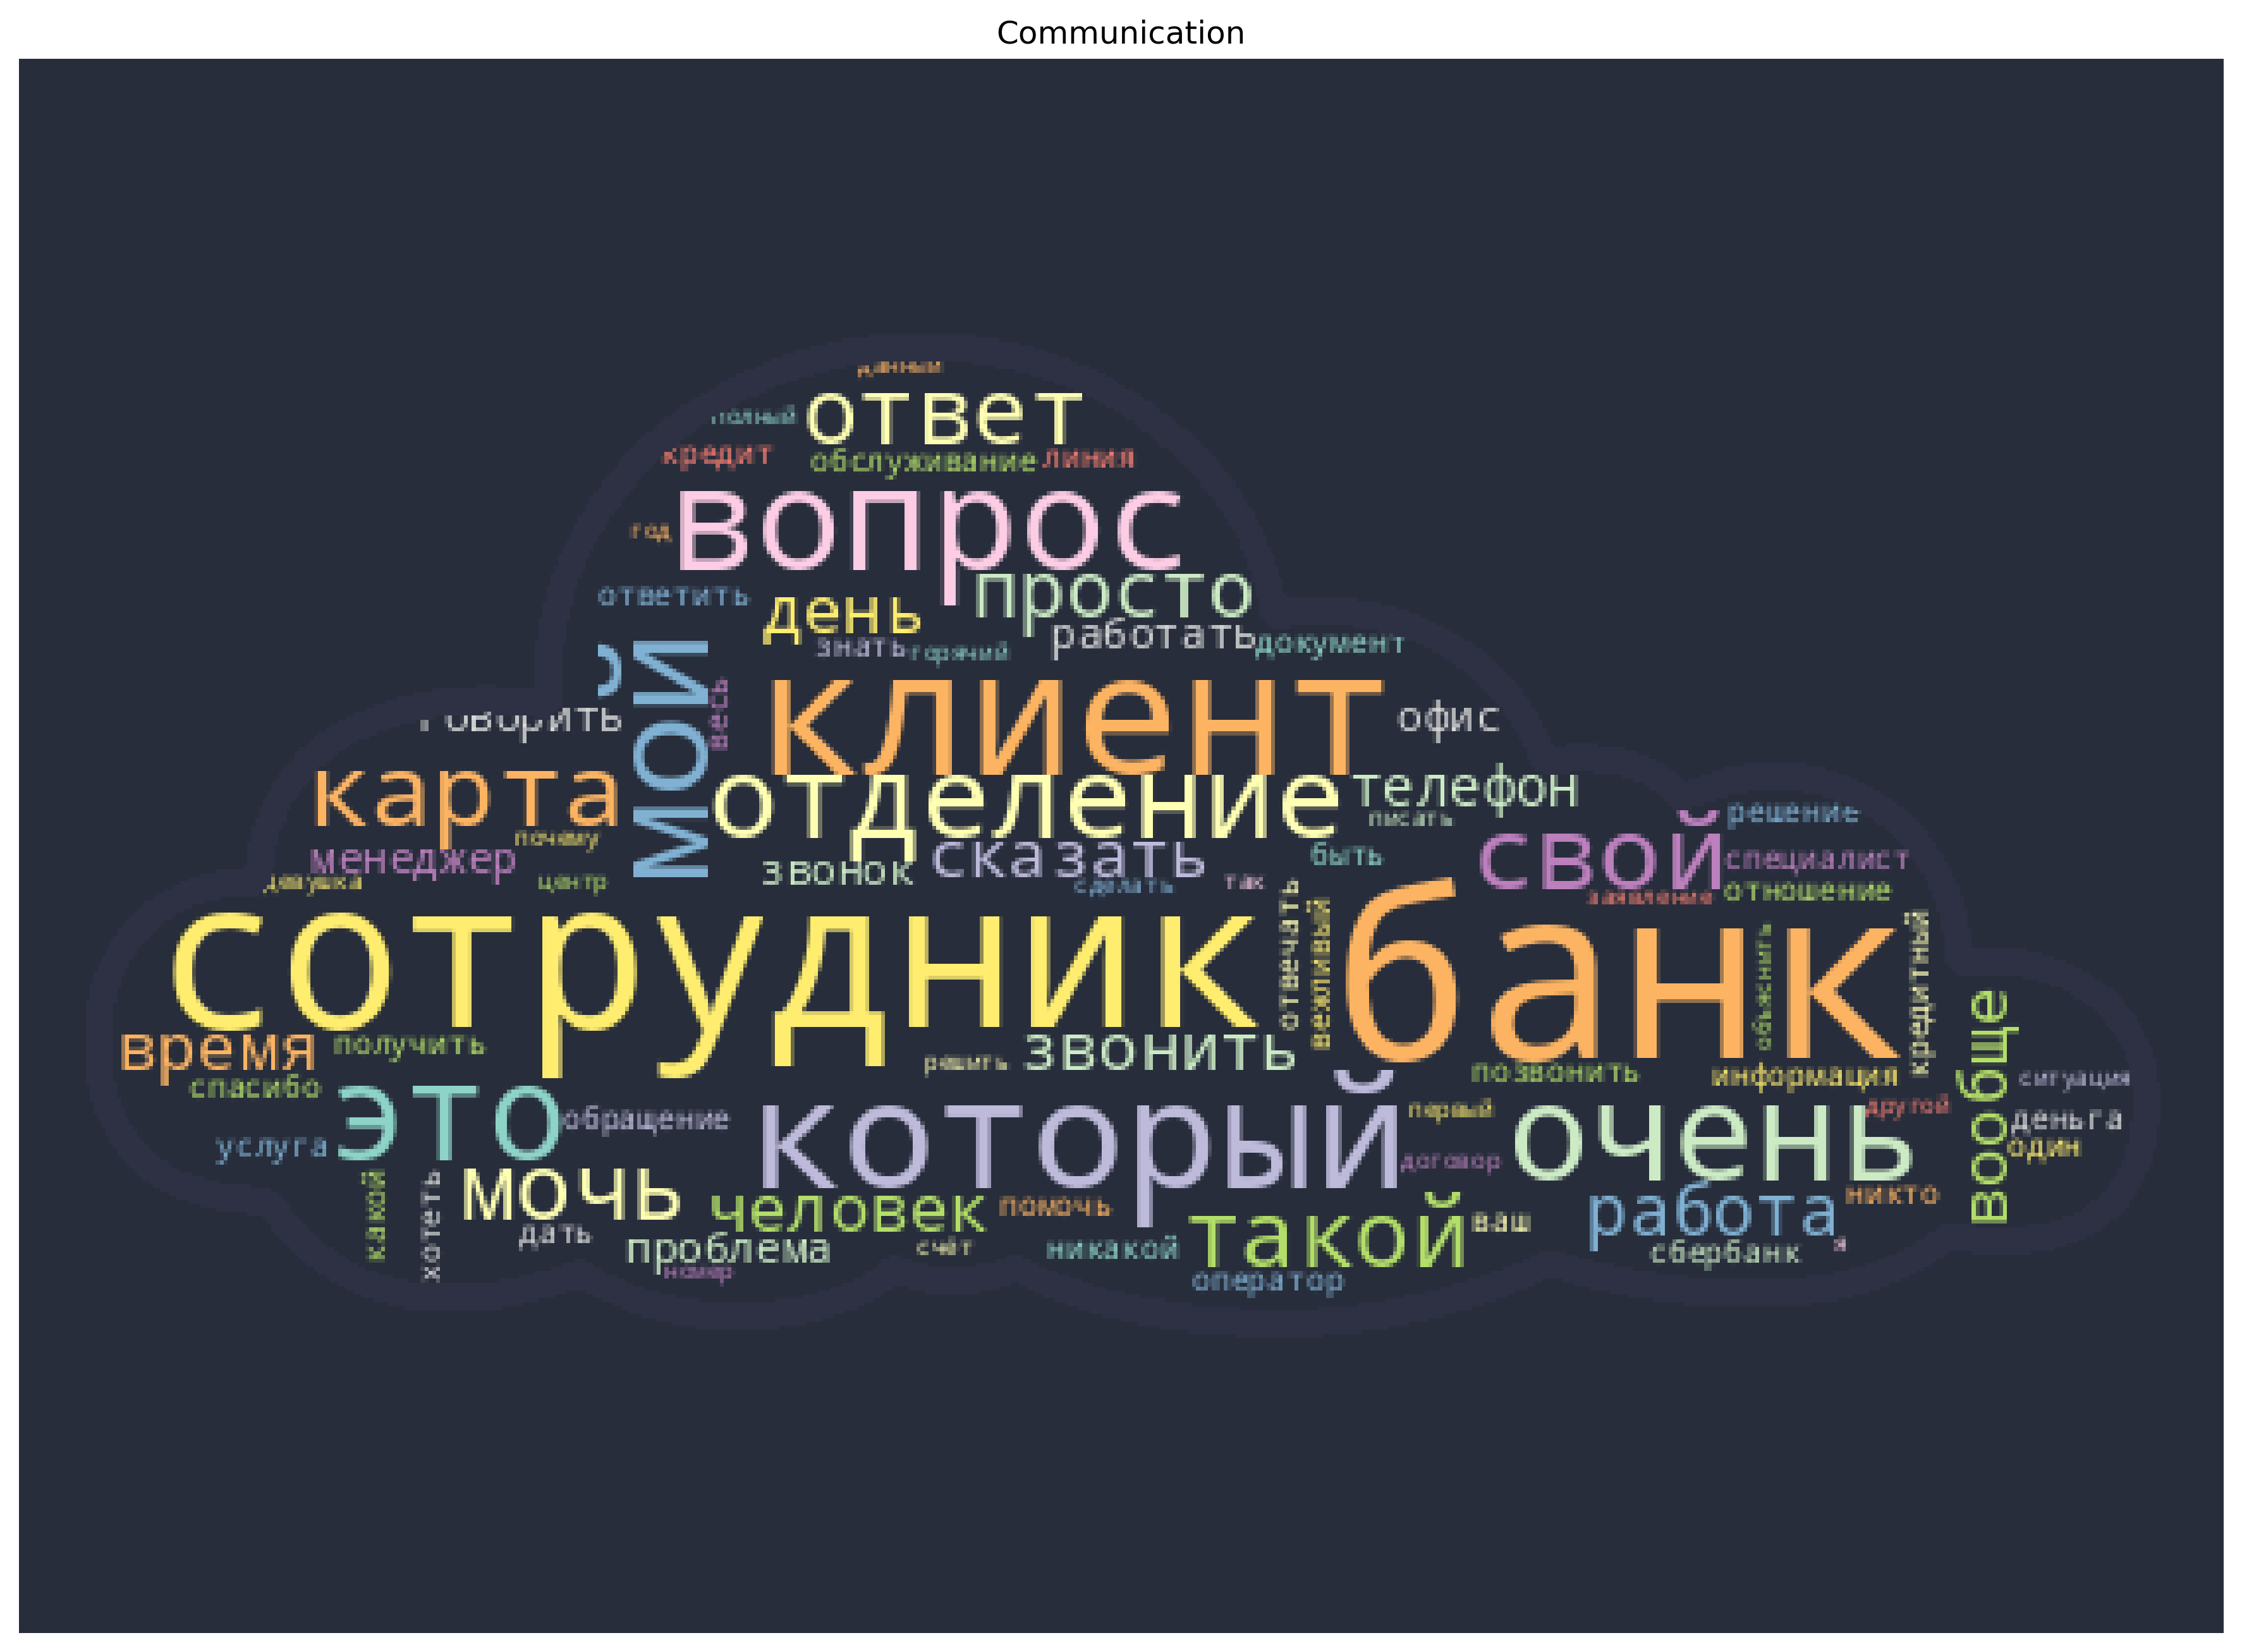

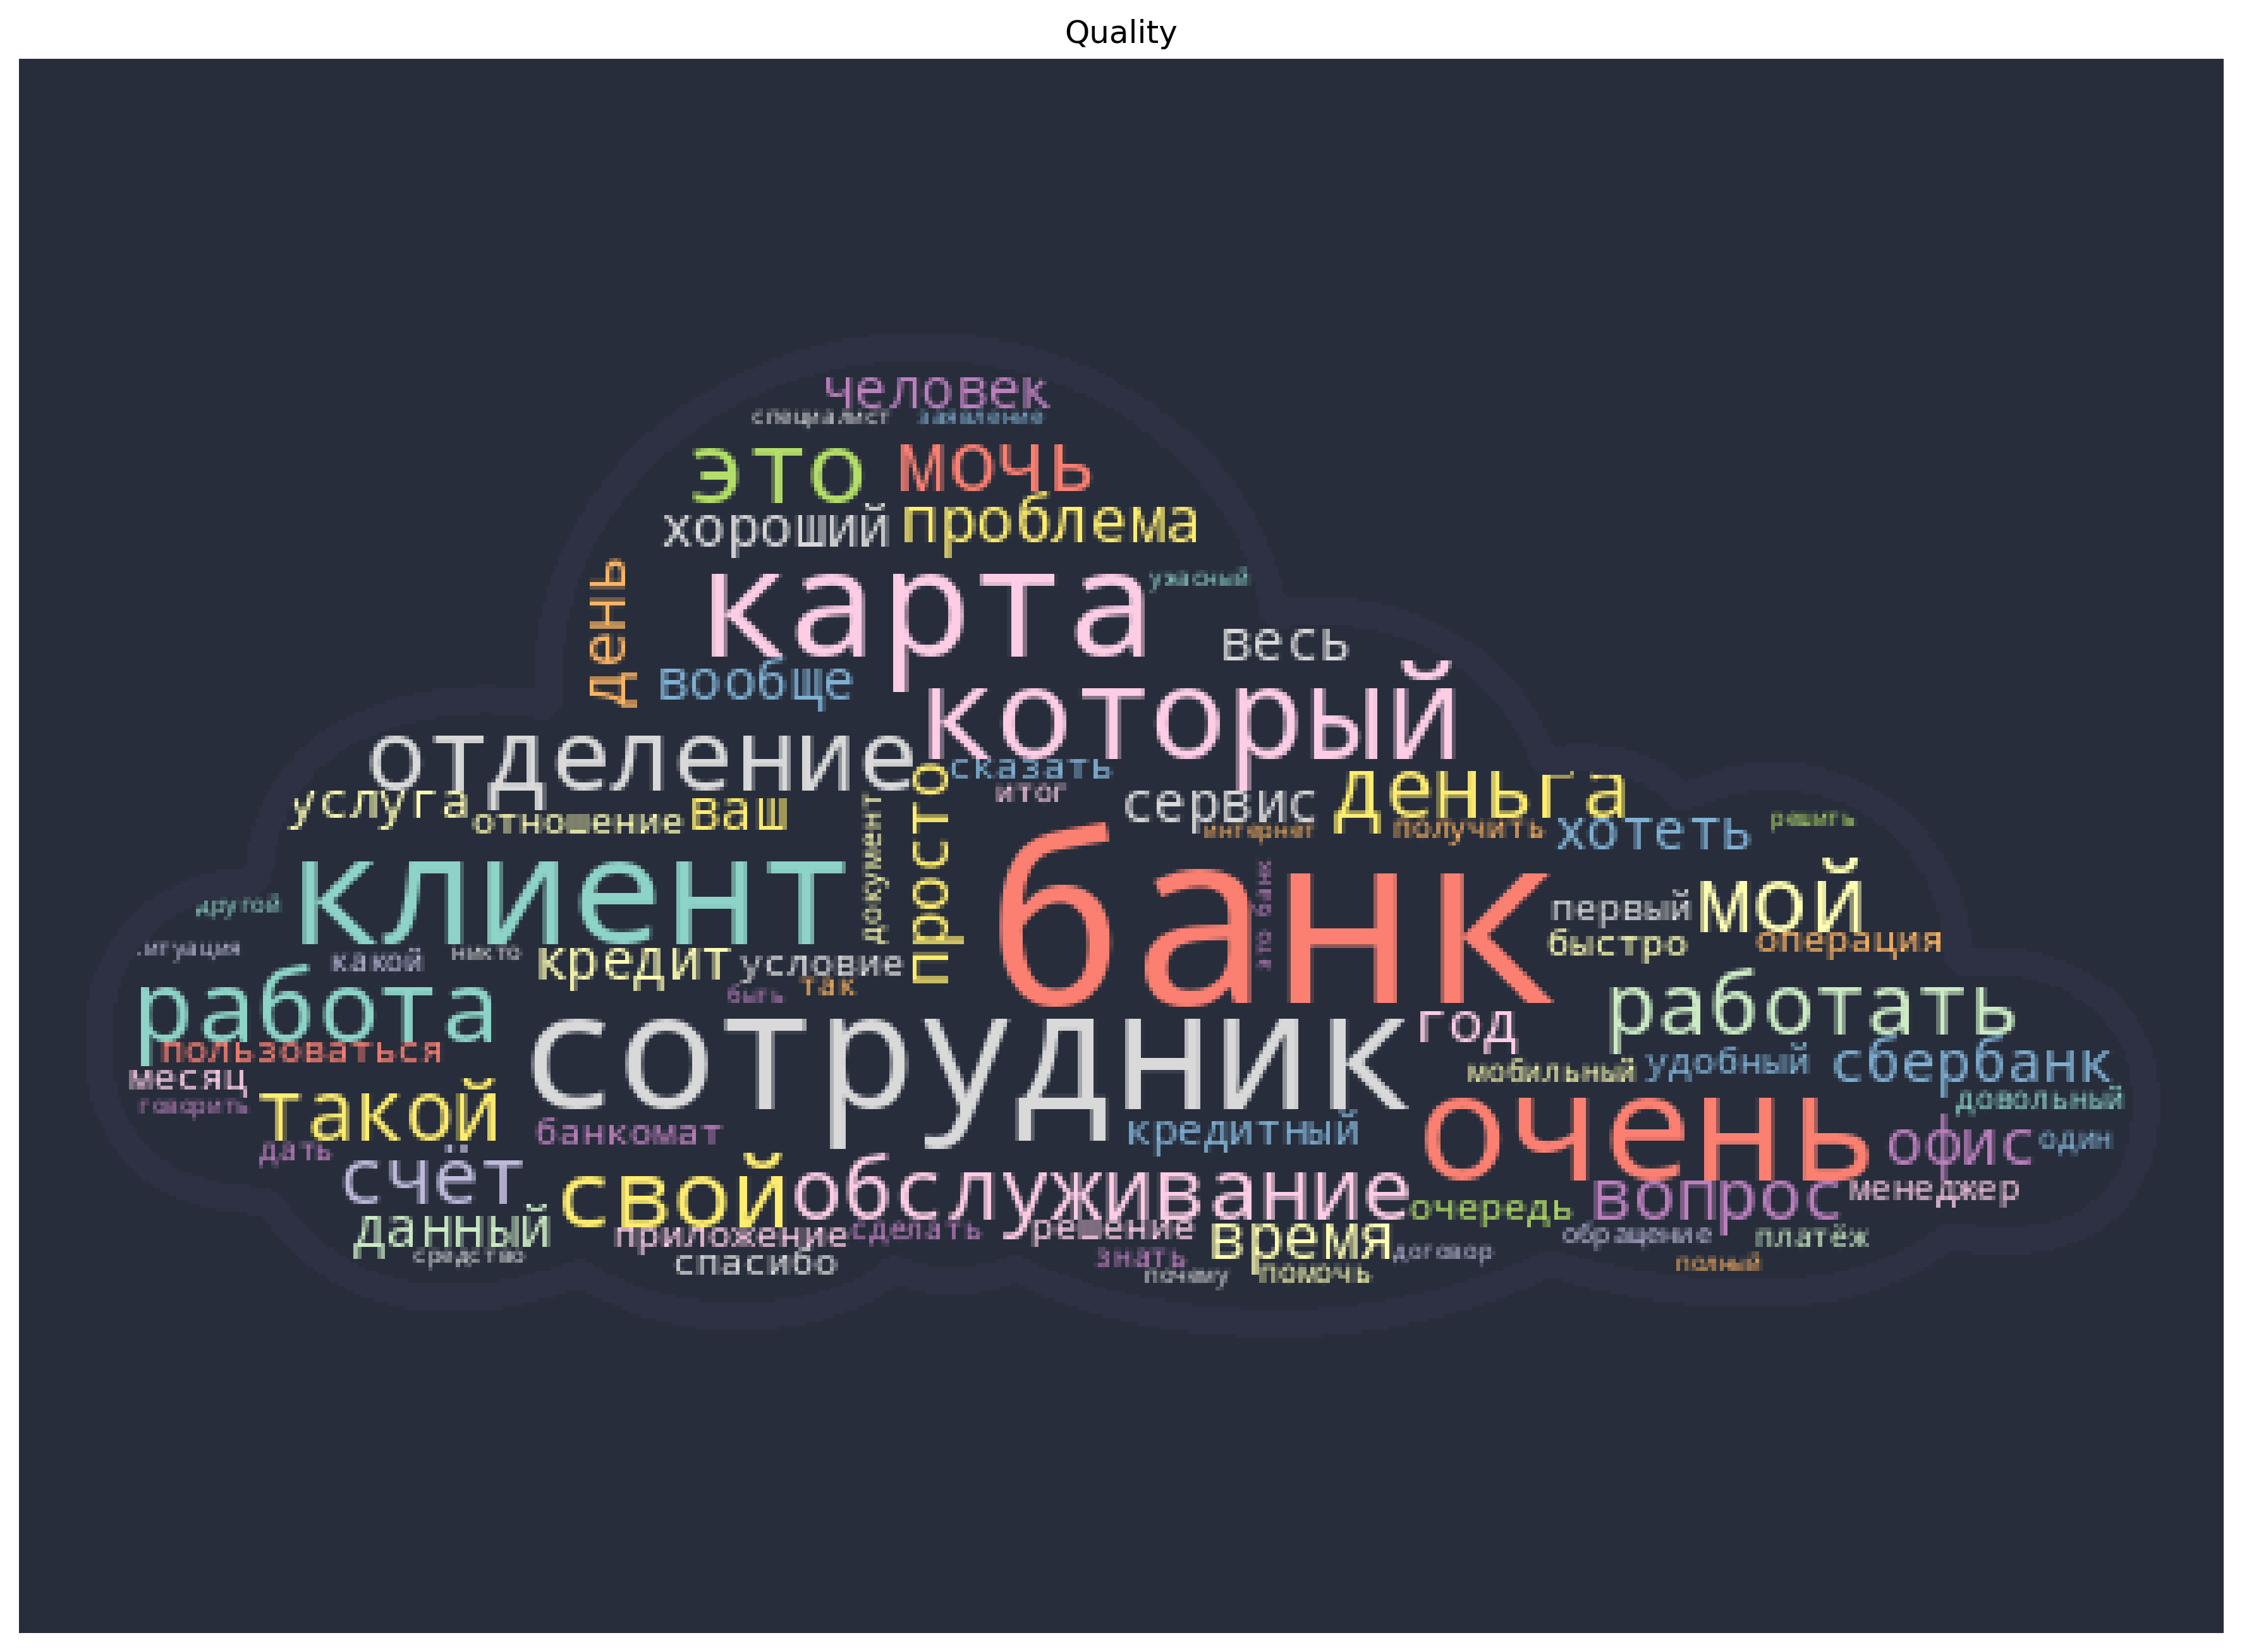

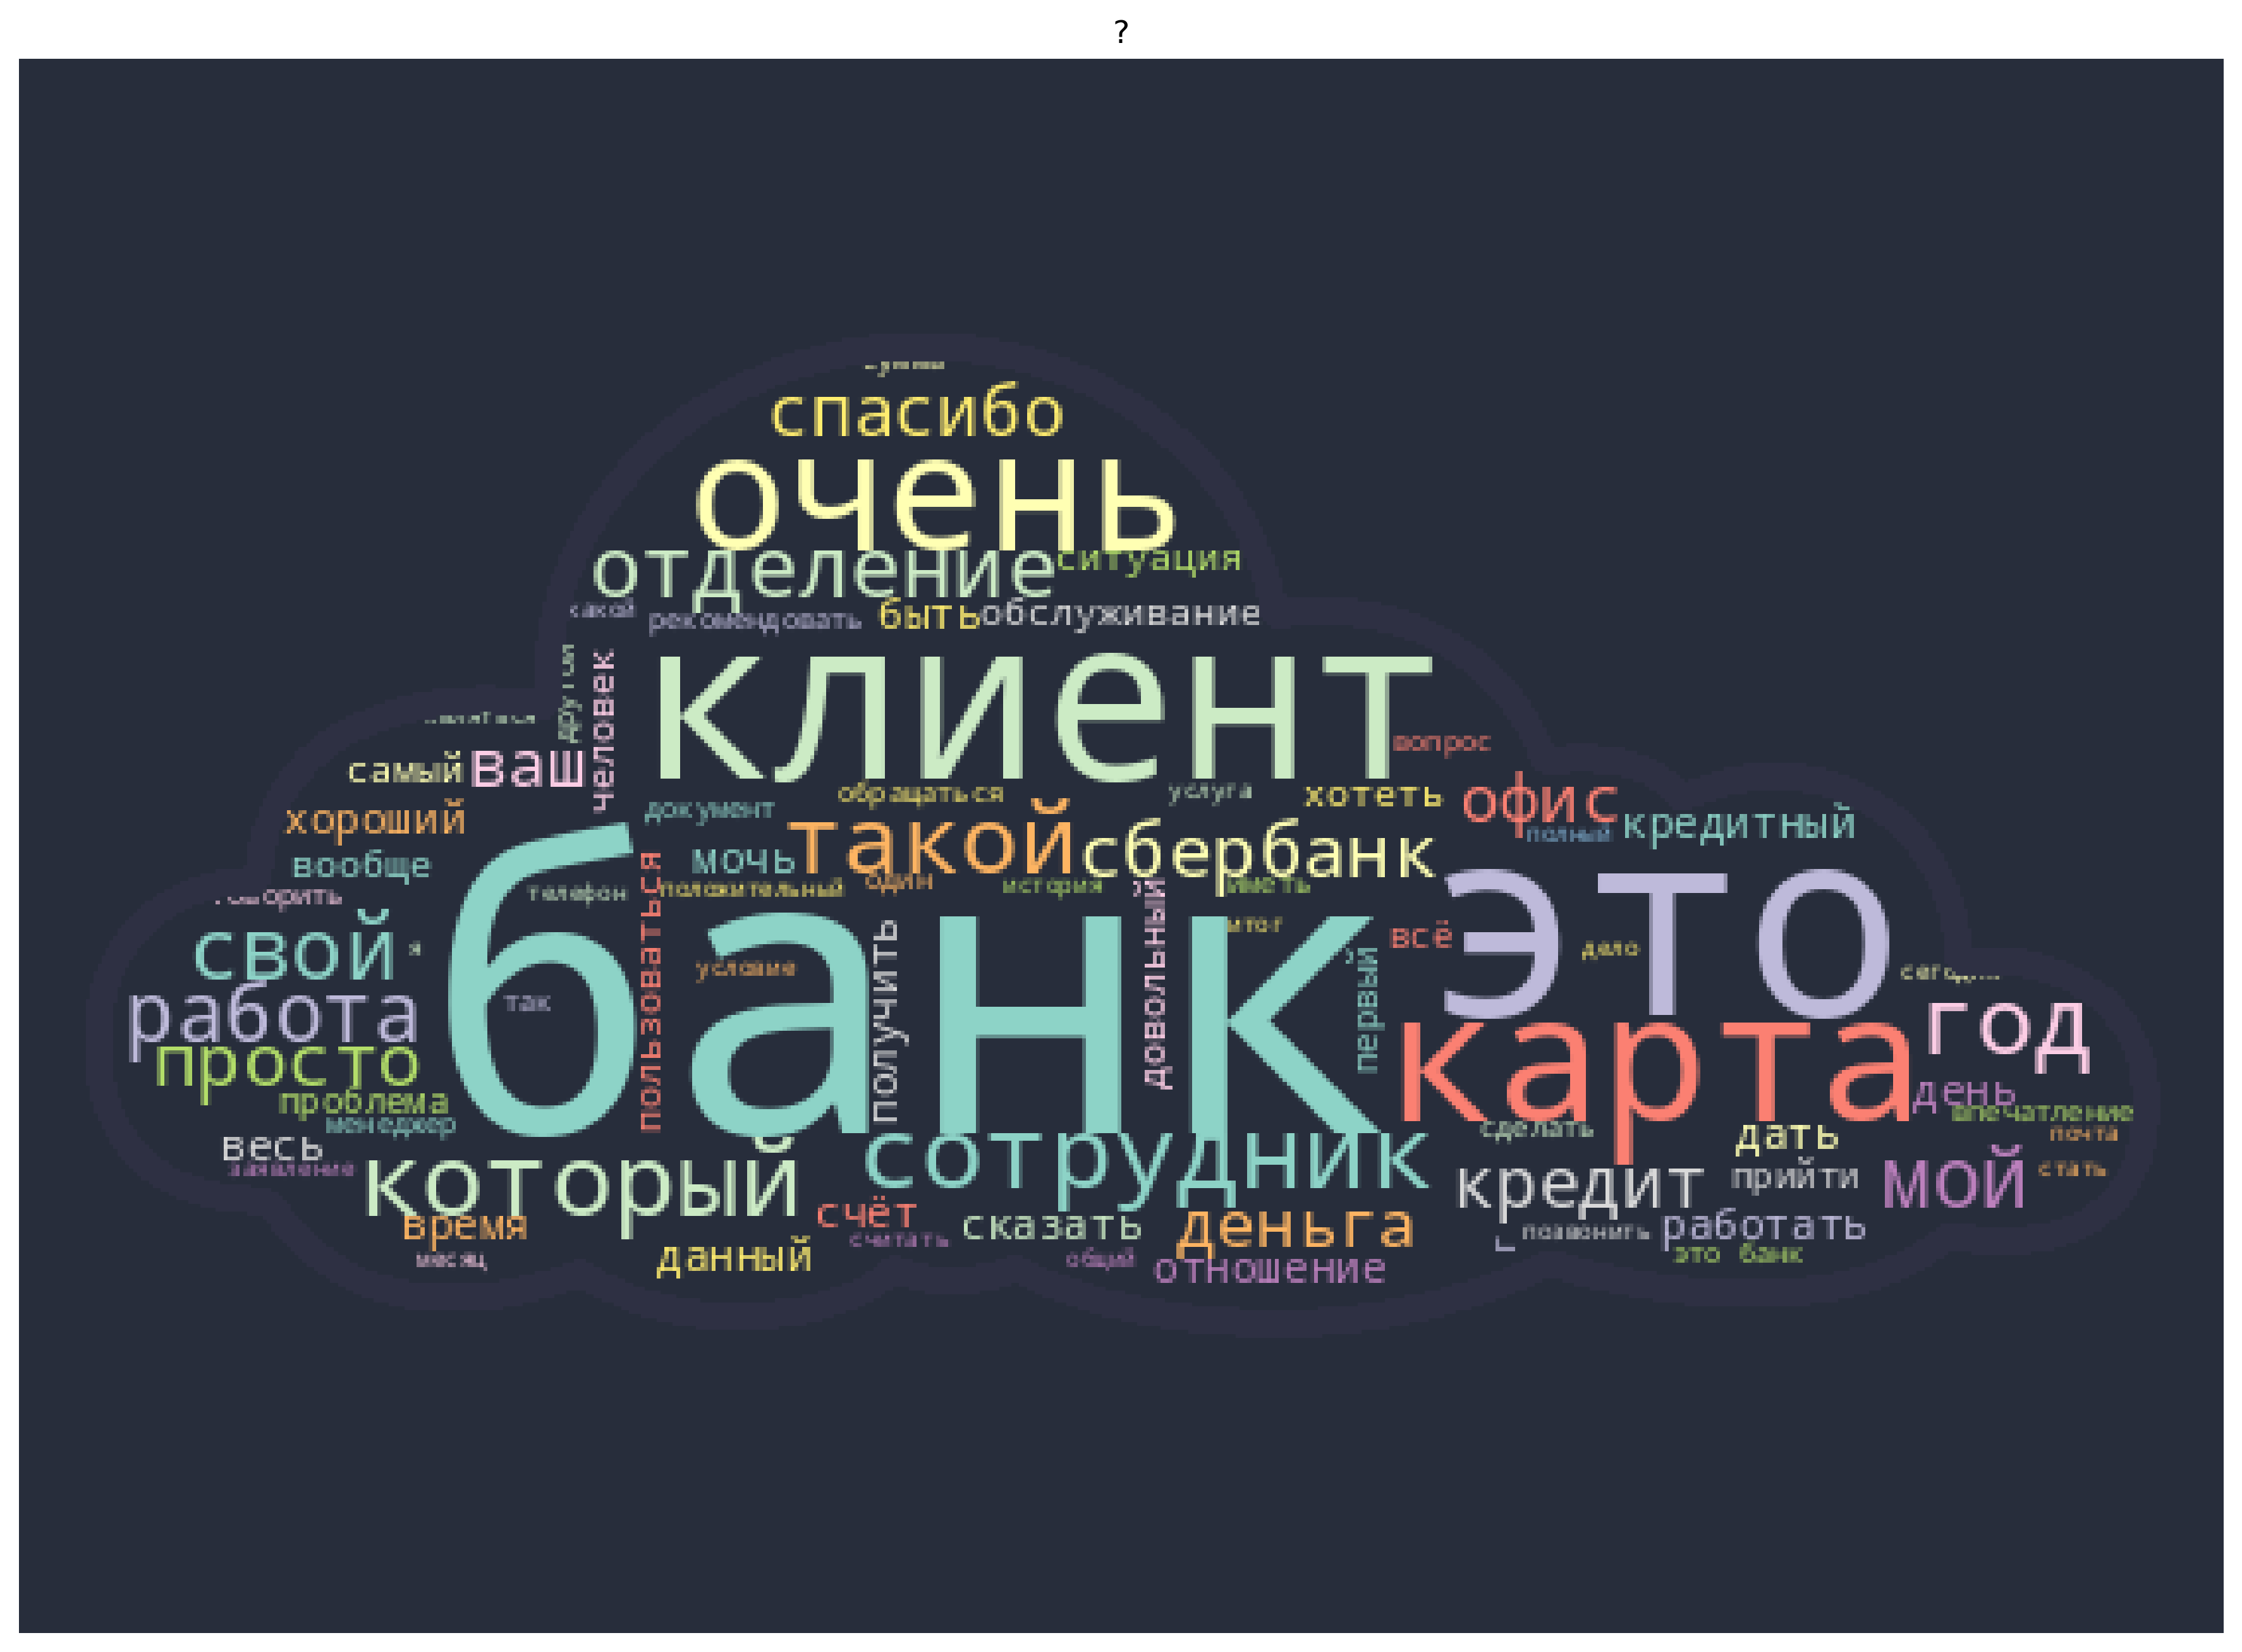

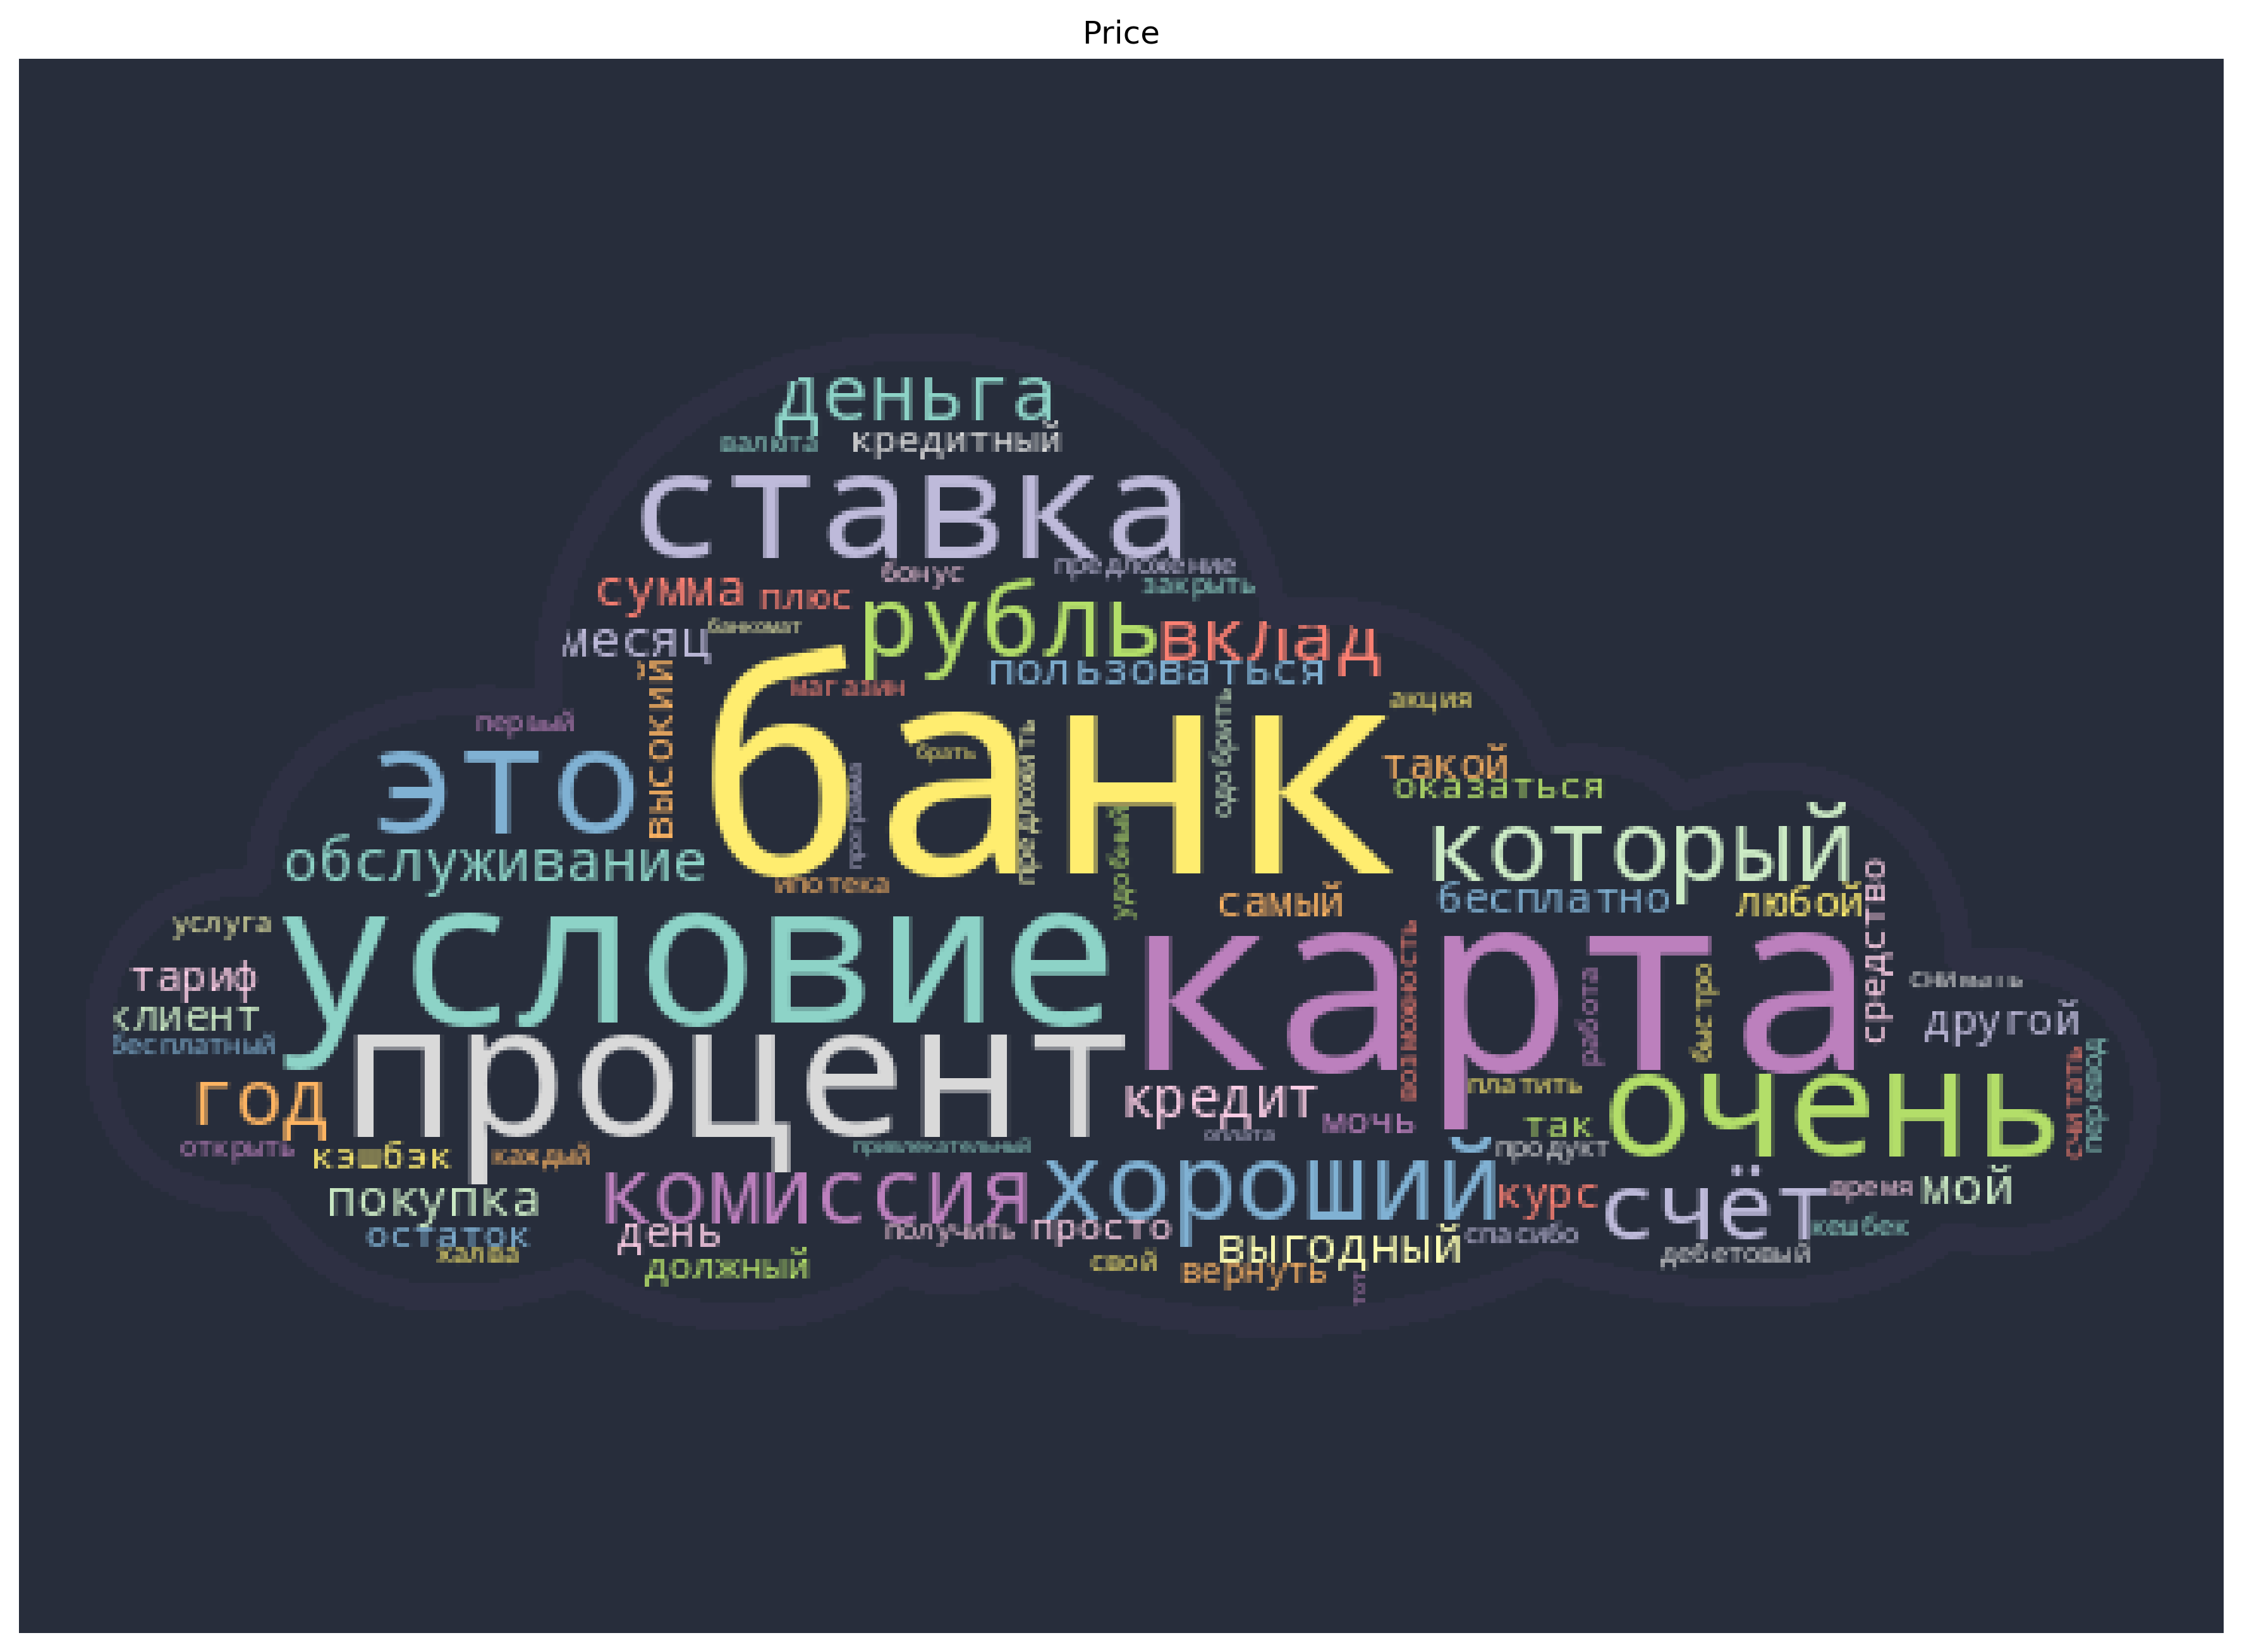

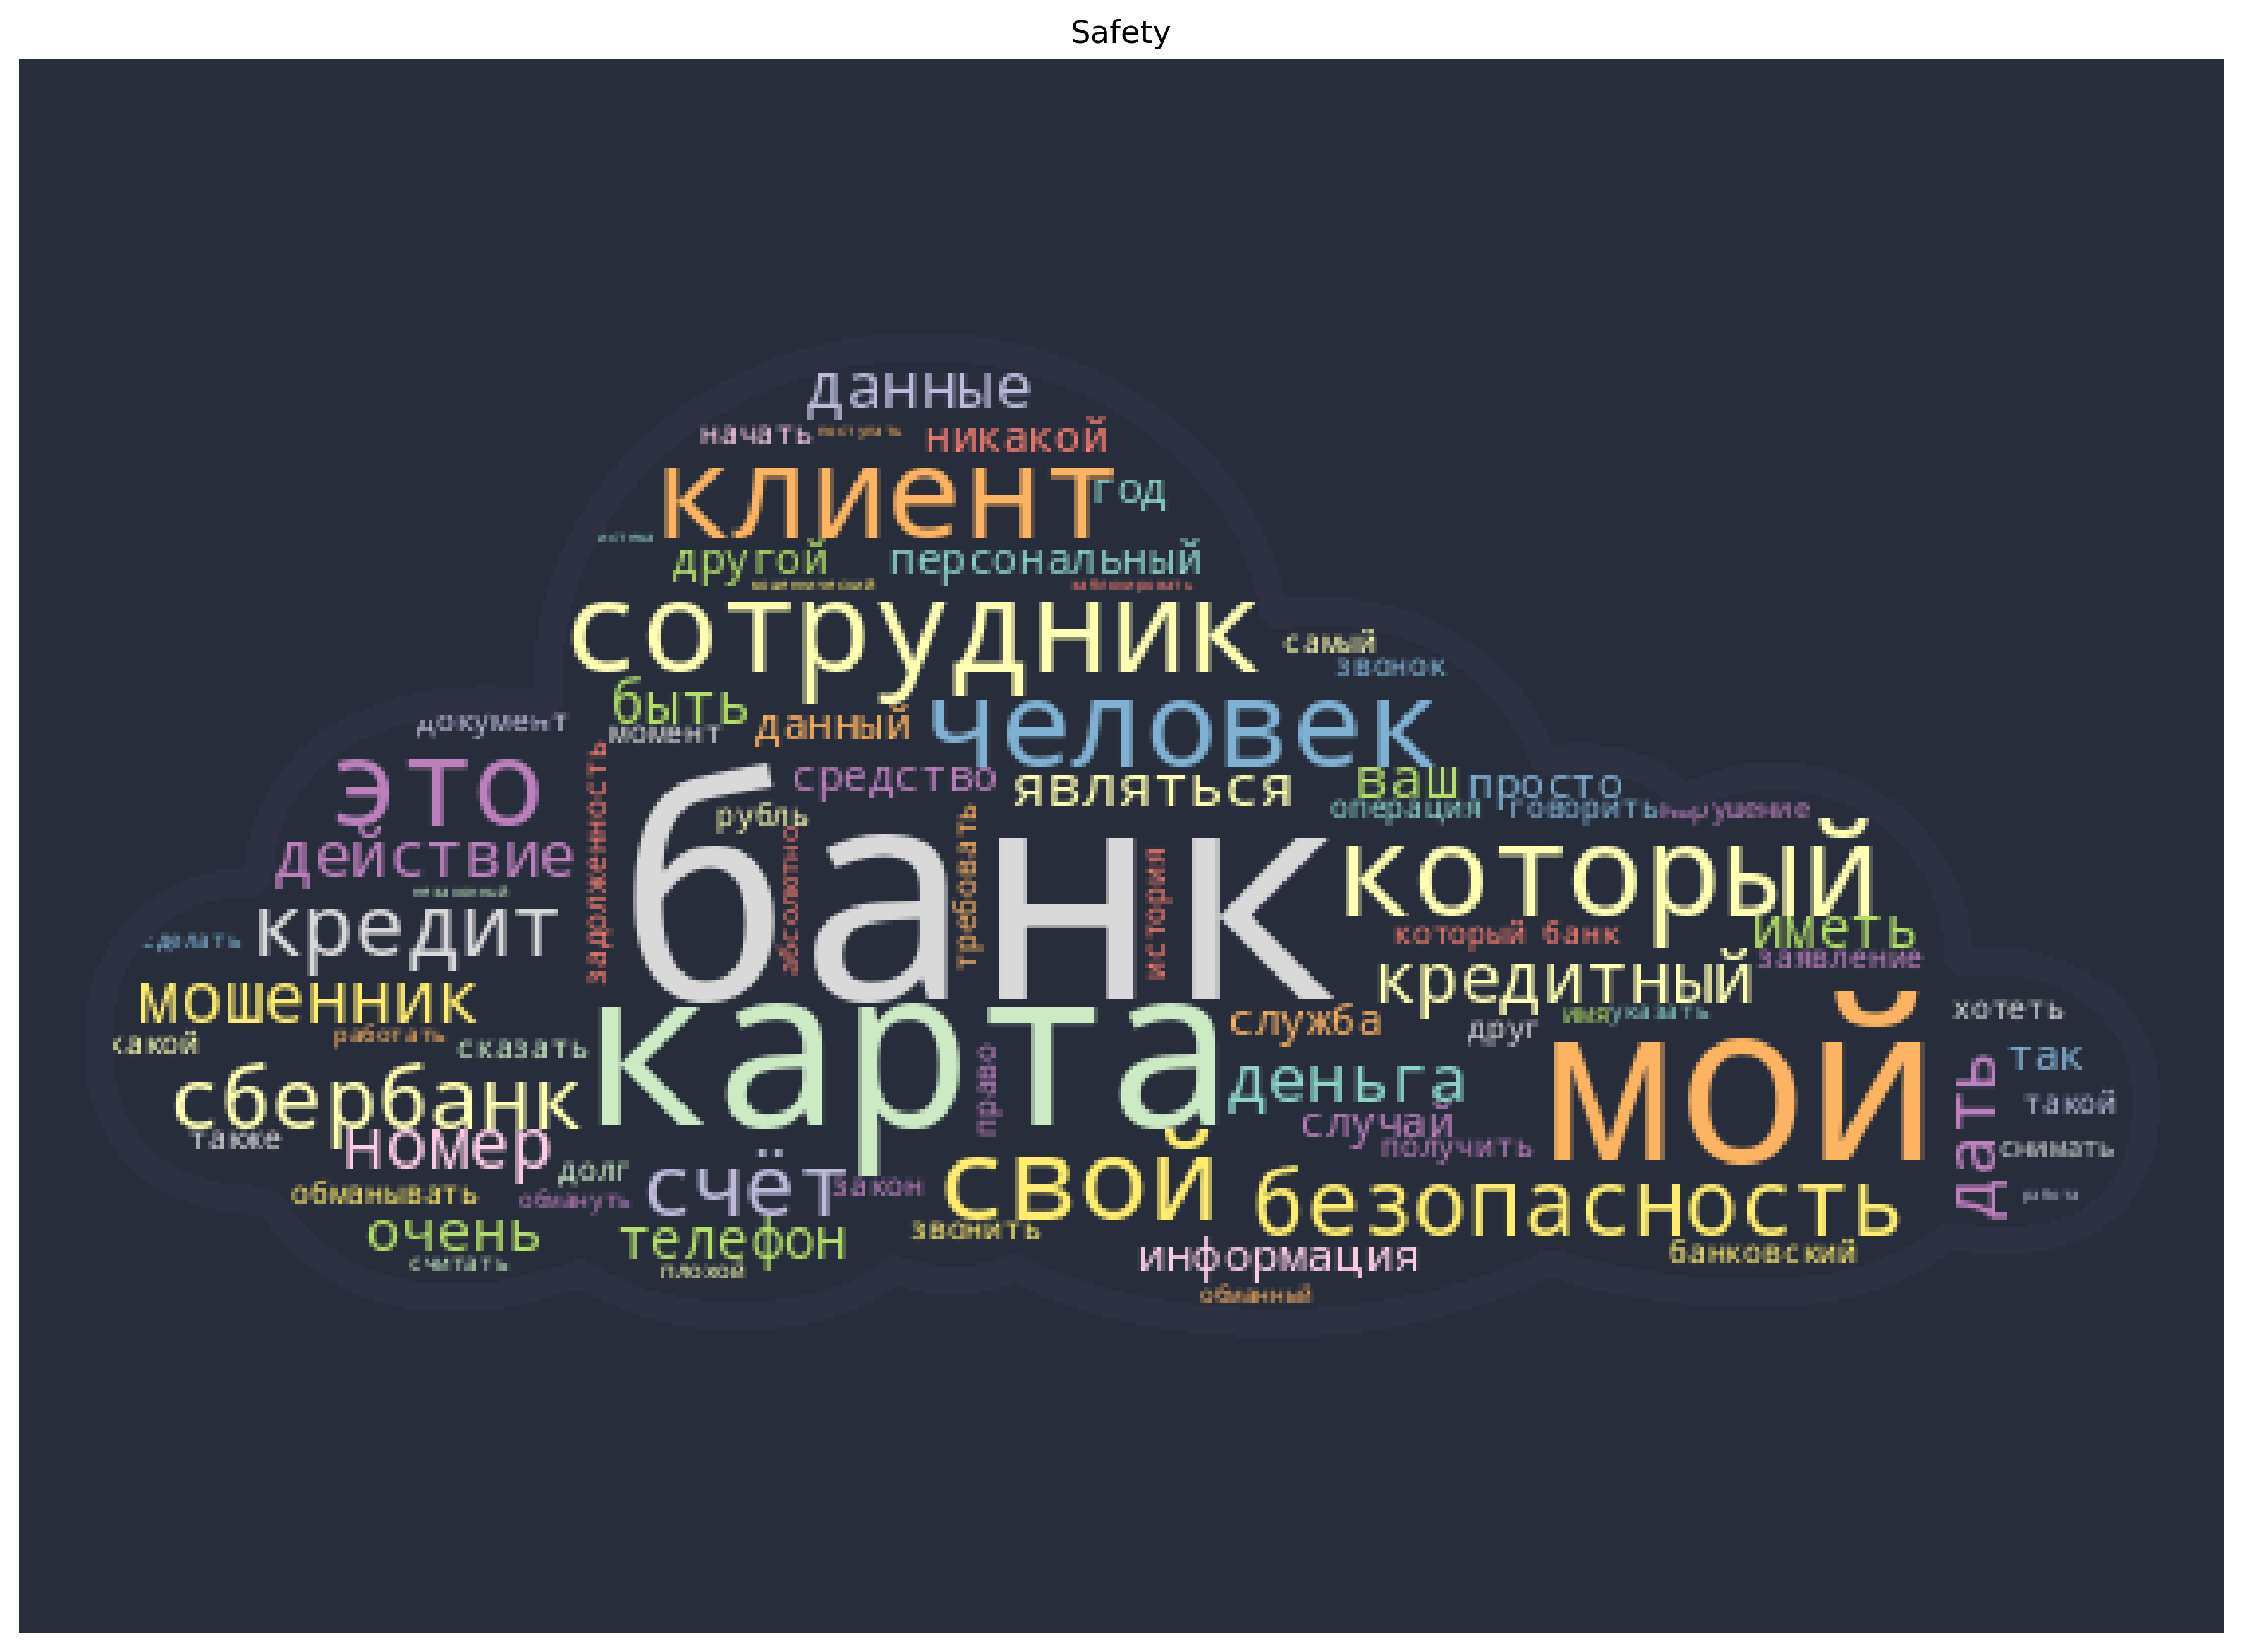

In [303]:
fig, axs = plt.subplots(5, 1, figsize=(15, 15), dpi=300)

for category in train_new["1category"].value_counts().index:
    fig, axs = plt.subplots(figsize=(15, 15), dpi=300)
    text_cat = ' '.join(train.lemma_string[train["1category"] == category])
 
    cloud = WordCloud(mask=cake_mask, contour_width=10, contour_color='#2e3043', background_color='#272d3b', colormap='Set3', max_words=80).generate(text_cat)
    axs.imshow(cloud)
    axs.set_axis_off()
    axs.set_title(category)

    fig.savefig(f'/home/jupyter/mnt/s3/bac2/media/{category}.svg', format='svg', dpi=1200)

# Валидация

In [295]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import classification_report

def accuracy(y, p):
    return sum(y == p) / len(y)

def cv(data):
    count_vectorizer = CountVectorizer()
    emb = count_vectorizer.fit_transform(data)
    return emb, count_vectorizer

def validate_C(X_train, X_test, y_train, y_test):
    c_best = 0
    best_accuracy = 0
    X_train_counts, count_vectorizer = cv(X_train)
    X_test_counts = count_vectorizer.transform(X_test)

    bow = count_vectorizer.fit_transform(X_train)

    for c in np.linspace(0.1,10,15):
        clf = LogisticRegression(C=c, max_iter=500, class_weight='balanced', solver='newton-cg', multi_class='multinomial', random_state=42)
        clf.fit(bow, y_train)
        pred = clf.predict(count_vectorizer.transform(X_test))
        res = classification_report(pred, y_test)
              
        val_accuracy = accuracy(y_test,pred)
        if val_accuracy > best_accuracy:
            best_accuracy = val_accuracy
            c_best = c
              
    print(f"Best c = {c}; accuracy = {best_accuracy}")        
    return c_best

Паратметр C для sentiments

In [296]:
X_train, X_test, y_train, y_test = train_test_split(train.lemma_string, train.sentiment, test_size=0.1, random_state=42)
C = validate_C(X_train, X_test, y_train, y_test)

Best c = 10.0; accuracy = 0.8776458440887971


Параметр С для category

In [297]:
X_train_cat, X_test_cat, y_train_cat, y_test_cat = train_test_split(train_new.lemma_string, train_new["1category"], test_size=0.1, random_state=42)
C_cat = validate_C(X_train_cat, X_test_cat, y_train_cat, y_test_cat)

Best c = 10.0; accuracy = 0.5776031434184676


# SVM

In [304]:
from sklearn import svm

def validate_svm(X_train, X_test, y_train, y_test):
    c_best = 0
    best_accuracy = 0
    X_train_counts, count_vectorizer = cv(X_train)
    X_test_counts = count_vectorizer.transform(X_test)

    bow = count_vectorizer.fit_transform(X_train)

    for c in np.linspace(0.1,10,10):
        clf = svm.SVC(decision_function_shape='ovo')
        clf.fit(bow, y_train)
        pred = clf.predict(count_vectorizer.transform(X_test))
        res = classification_report(pred, y_test)
        
        val_accuracy = accuracy(y_test, pred)
        if val_accuracy > best_accuracy:
            best_accuracy = val_accuracy
            c_best = c
              
    print(f"Best c = {c}; accuracy = {best_accuracy}")        
    return c_best

In [305]:
c = validate_svm(X_train, X_test, y_train, y_test)

Best c = 10.0; accuracy = 0.8874548270521425


In [ ]:
c_cat = validate_svm(X_train_cat, X_test_cat, y_train_cat, y_test_cat)

# Визуализация sentiment Bag of words

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(train.lemma_string, train.sentiment, test_size=0.2, random_state=42)

X_train_counts, count_vectorizer = cv(X_train)
X_test_counts = count_vectorizer.transform(X_test)

bow = count_vectorizer.fit_transform(X_train)
clf = LogisticRegression(C=2, max_iter=500, class_weight='balanced', solver='newton-cg', multi_class='multinomial',random_state=42)
clf.fit(bow, y_train)

In [ ]:
def get_most_important_features(vectorizer, model, n=5):
    index_to_word = {v:k for k,v in vectorizer.vocabulary_.items()}
    
    classes ={}
    for class_index in range(model.coef_.shape[0]):
        word_importances = [(el, index_to_word[i]) for i,el in enumerate(model.coef_[class_index])]
        sorted_coeff = sorted(word_importances, key = lambda x : x[0], reverse=True)
        tops = sorted(sorted_coeff[:n], key = lambda x : x[0])
        classes[class_index] = {
            'tops':tops,
        }
    return classes

importance = get_most_important_features(count_vectorizer, clf, 10)

In [ ]:
def plot_important_words(top_scores_p, top_words_p, top_scores_neut, top_words_neut, top_scores_neg, top_words_neg):
    
    y_pos_p = np.arange(len(top_words_p))
    top_pairs_p = [(a,b) for a,b in zip(top_words_p, top_scores_p)]
    top_pairs_p = sorted(top_pairs_p, key=lambda x: x[1])

    top_words_p = [a[0] for a in top_pairs_p]
    top_scores_p = [a[1] for a in top_pairs_p]

    
    y_pos_neut = np.arange(len(top_words_neut))
    top_pairs_neut = [(a,b) for a,b in zip(top_words_neut, top_scores_neut)]
    top_pairs_neut = sorted(top_pairs_neut, key=lambda x: x[1])

    top_words_neut = [a[0] for a in top_pairs_neut]
    top_scores_neut = [a[1] for a in top_pairs_neut]
    
    
    y_pos_neg = np.arange(len(top_words_neg))
    top_pairs_neg = [(a,b) for a,b in zip(top_words_neg, top_scores_neg)]
    top_pairs_neg = sorted(top_pairs_neg, key=lambda x: x[1])

    
    top_words_neg = [a[0] for a in top_pairs_neg]
    top_scores_neg = [a[1] for a in top_pairs_neg]
    
    f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 5), dpi=300)
    f.suptitle("Sentiment", fontsize=20)
    ax1.barh(top_words_p, y_pos_p, color='g')
    ax1.set_title('+')
    ax1.xaxis.set_label_text('Importance', fontsize=10)
    
    ax2.barh(top_words_neut, y_pos_neut, color='b')
    ax2.set_title('?')
    ax2.xaxis.set_label_text('Importance', fontsize=10)
    
    ax3.barh(top_words_neg, y_pos_neg, color='r')
    ax3.set_title('-')
    ax3.xaxis.set_label_text('Importance', fontsize=10)

    plt.subplots_adjust(wspace=0.8)
    f.savefig(f'/home/jupyter/mnt/s3/bac2/media/BoW_sentiments.png', format='png', dpi=1200)
    
top_scores_p = [a[0] for a in importance[0]['tops']]
top_words_p = [a[1] for a in importance[0]['tops']]
top_scores_neut = [a[0] for a in importance[1]['tops']]
top_words_neut = [a[1] for a in importance[1]['tops']]
top_scores_neg = [a[0] for a in importance[2]['tops']]
top_words_neg = [a[1] for a in importance[2]['tops']]

plot_important_words(top_scores_p, top_words_p, top_scores_neut, top_words_neut, top_scores_neg, top_words_neg)

# Визуализация категорий Bag of words

In [ ]:
X_train_cat, X_test_cat, y_train_cat, y_test_cat = train_test_split(train_new.lemma_string, train_new["1category"], test_size=0.2, random_state=42)

X_train_counts_cat, count_vectorizer_cat = cv(X_train_cat)
X_test_counts_cat = count_vectorizer_cat.transform(X_test_cat)

bow_cat = count_vectorizer.fit_transform(X_train_cat)
clf_cat = LogisticRegression(C=2, max_iter=500, class_weight='balanced', solver='newton-cg', multi_class='multinomial',random_state=42)
clf_cat.fit(bow_cat, y_train_cat);

In [ ]:
importance_cat = get_most_important_features(count_vectorizer_cat, clf_cat, 10)

In [ ]:
def plot_important_words_cat(importance):
    
    top_scores_neut = [a[0] for a in importance[0]['tops']]
    top_words_neut = [a[1] for a in importance[0]['tops']]
    top_scores_com = [a[0] for a in importance[1]['tops']]
    top_words_com = [a[1] for a in importance[1]['tops']]
    top_scores_pr = [a[0] for a in importance[2]['tops']]
    top_words_pr = [a[1] for a in importance[2]['tops']]
    top_scores_qual = [a[0] for a in importance[3]['tops']]
    top_words_qual = [a[1] for a in importance[3]['tops']]
    top_scores_saf = [a[0] for a in importance[4]['tops']]
    top_words_saf = [a[1] for a in importance[4]['tops']]
    
    y_pos_neut = np.arange(len(top_words_neut))
    top_pairs_neut = [(a,b) for a,b in zip(top_words_neut, top_scores_neut)]
    top_pairs_neut = sorted(top_pairs_neut, key=lambda x: x[1])

    top_words_neut = [a[0] for a in top_pairs_neut]
    top_scores_neut = [a[1] for a in top_pairs_neut]

    
    y_pos_com = np.arange(len(top_words_com))
    top_pairs_com = [(a,b) for a,b in zip(top_words_com, top_scores_com)]
    top_pairs_com = sorted(top_pairs_com, key=lambda x: x[1])

    top_words_com = [a[0] for a in top_pairs_com]
    top_scores_com = [a[1] for a in top_pairs_com]
    
    
    y_pos_pr = np.arange(len(top_words_pr))
    top_pairs_pr = [(a,b) for a,b in zip(top_words_pr, top_scores_pr)]
    top_pairs_pr = sorted(top_pairs_pr, key=lambda x: x[1])

    
    top_words_pr = [a[0] for a in top_pairs_pr]
    top_scores_pr = [a[1] for a in top_pairs_pr]
    
    y_pos_qual = np.arange(len(top_words_qual))
    top_pairs_qual = [(a,b) for a,b in zip(top_words_qual, top_scores_qual)]
    top_pairs_qual = sorted(top_pairs_qual, key=lambda x: x[1])

    top_words_qual = [a[0] for a in top_pairs_qual]
    top_scores_qual = [a[1] for a in top_pairs_qual]
    
    
    y_pos_saf = np.arange(len(top_words_saf))
    top_pairs_saf = [(a,b) for a,b in zip(top_words_saf, top_scores_saf)]
    top_pairs_saf = sorted(top_pairs_saf, key=lambda x: x[1])

    
    top_words_saf = [a[0] for a in top_pairs_saf]
    top_scores_saf = [a[1] for a in top_pairs_saf]
    
    f, (ax1, ax2, ax3) = plt.subplots(3, 2, figsize=(12, 8), dpi=300)
    f.suptitle("Categories", fontsize=20)
    
    ax1[0].barh(top_words_saf, y_pos_saf, align='center', color='c')
    ax1[0].set_title('Safety')
    ax1[0].xaxis.set_label_text('Importance', fontsize=10)
    
    ax1[1].barh(top_words_com, y_pos_com, color='b')
    ax1[1].set_title('Communication')
    ax1[1].xaxis.set_label_text('Importance', fontsize=10)
    
    ax2[0].barh(top_words_pr, y_pos_pr, color='r')
    ax2[0].set_title('Price')
    ax2[0].xaxis.set_label_text('Importance', fontsize=10)
    
    ax2[1].barh(top_words_qual, y_pos_qual, color='y')
    ax2[1].set_title('Quality')
    ax2[1].xaxis.set_label_text('Importance', fontsize=10)
    
    ax3[0].barh(top_words_neut, y_pos_neut, color='g')
    ax3[0].set_title('?')
    ax3[0].xaxis.set_label_text('Importance', fontsize=10)
    
    ax3[1].remove()
    
    plt.subplots_adjust(wspace=0.8, hspace=0.5)
    
    f.savefig(f'/home/jupyter/mnt/s3/bac2/media/BoW_categories.png', format='png', dpi=1200)

In [ ]:
plot_important_words_cat(importance_cat)